# **Кейс-чемпионат Changellenge >> Cup IT 2023**

Данная работа была выполнена как часть командного проекта в рамках [хакатона Cup IT 2023](https://changellenge.com/tpage/changellenge-cup-it-2023-first-tour/#).

**Постановка задачи**  

Предложите механизм сортировки комментариев к постам по их популярности на основе методов машинного обучения, чтобы модель могла как можно лучше ранжировать пользовательские комментарии.

**1.** Проведите проверку и разведочный анализ данных (EDA) и подумайте, какие готовые решения можно использовать для представления текста.

**2.** Используя тренировочную и тестовую выборки датасета, обучите модель ранжировать текстовые комментарии в порядке их популярности (от популярных к менее популярным) и проведите валидацию своей модели. Выбор модели необходимо аргументировать, основываясь на результатах обучения.

**3.** Проанализируйте полученные результаты и сформулируйте полезные инсайты о том, что обычно содержит популярный комментарий, чтобы команда VK могла использовать эту информацию для улучшения комментариев своих пользователей.

**4.** Предложите методы взаимодействия с комментаторами, а также механизмы поддержки для разных групп пользователей, включая тех, чьи комментарии непопулярны.

In [159]:
# основные библиотеки
import pandas as pd
import numpy as np
import json

# семантический анализ
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from afinn import Afinn
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer
import re
import string

# визуализация
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRanker
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

## <center> **Загрузка и первичная обработка данных**

In [2]:
# функция загрузки датасета
def load(path):
    """функция для загрузки датасета и первичной его обработка"""
    
    comment_data = pd.read_json(path, lines=True, orient="records", encoding="windows-1251")
    comment_data.rename({"text":"post"}, inplace=True, axis=1)
    comment_data.set_index("post", inplace=True)
    comment_data = comment_data.explode(column="comments")
    comments = pd.json_normalize(comment_data["comments"])
    comments.set_index(comment_data.index, inplace=True)
    comment_data = pd.concat([comment_data, comments], axis=1)
    comment_data.drop("comments", axis=1, inplace=True)
    comment_data.reset_index(inplace=True)
    comment_data['text'] = comment_data['text'].str.replace("&#x27;", "'")
    del comments
    
    return comment_data

In [3]:
# загружаем наши датасеты
train_df = load("files/ranking_train.jsonl")
test_df = load("files/ranking_test.jsonl")

После первичной обработки датасет содержит столбец с постом, столбец с одним комментарием к нему (5 комментариев на каждый пост) и рейтинг комментария от 0 (наиболее важный) до 4 (наименее важный). Каким образом была эта оценка получена история, к сожалению, умалчивает. Аналогично нам неизвестен источник постов и комментариев и их каким образом они были отобраны.

In [4]:
# отобразим 5 комментариев для первого поста
train_df.head(5)

,post,text,score
0,How many summer Y Combinator fundees decided n...,Going back to school is not identical with giv...,0
1,How many summer Y Combinator fundees decided n...,There will invariably be those who don't see t...,1
2,How many summer Y Combinator fundees decided n...,For me school is a way to be connected to what...,2
3,How many summer Y Combinator fundees decided n...,I guess it really depends on how hungry you ar...,3
4,How many summer Y Combinator fundees decided n...,I know pollground decided to go back to school...,4
...,...,...,...
440530,Pay your rent with a Credit or Debit card. No ...,Most major banks offer a service called 'bill ...,0
440531,Pay your rent with a Credit or Debit card. No ...,"It costs 3.25%, or $74.25 for the example of $...",1
440532,Pay your rent with a Credit or Debit card. No ...,As many other comments have pointed out almost...,2
440533,Pay your rent with a Credit or Debit card. No ...,My apartment building uses Yapstone's RentPaym...,3


Для проведения анализа данных, поиска зависимостей и связей между комментариями и постами, векторный анализ не очень подходит. Поэтому было принято решение использовать семантический анализ.

## <center> **Построение и отбор признаков**

### Sentiment Intensity Analyzer

Сделаем анализ для текста комментариев.

In [5]:
# вызываем основной метод этой библиотеки
sia_analysis = SentimentIntensityAnalyzer()

def sia_text_analysis(df):
    """функция для получения различных коэффициентов семантической окраски текста комментария"""
    
    # словарь со всеми значениями анализа
    df['text_sia'] = df['text'].apply(lambda x: sia_analysis.polarity_scores(x))
    
    # получаем показатель негативности, нейтральности и позитивности
    df['text_neg'] = df['text_sia'].apply(lambda x: x['neg'])
    df['text_neu'] = df['text_sia'].apply(lambda x: x['neu'])
    df['text_pos'] = df['text_sia'].apply(lambda x: x['pos'])
    
    # главный параметр библиотеки SIA
    df['text_compound'] = df['text_sia'].apply(lambda x: x['compound'])
    
    # избавляемся от более ненужного признака
    df = df.drop('text_sia', axis=1)
    
    return df


# применяем к нашим выборкам
train_df = sia_text_analysis(train_df)
test_df = sia_text_analysis(test_df)

А теперь для текста самого поста.

In [6]:
# вызываем основной метод этой библиотеки
sia_analysis = SentimentIntensityAnalyzer()

def sia_post_analysis(df):
    """функция для получения различных коэффициентов семантической окраски текста поста"""
    
    # словарь со всеми значениями анализа
    df['post_sia'] = df['post'].apply(lambda x: sia_analysis.polarity_scores(x))
    
    # получаем показатель негативности, нейтральности и позитивности
    df['post_neg'] = df['post_sia'].apply(lambda x: x['neg'])
    df['post_neu'] = df['post_sia'].apply(lambda x: x['neu'])
    df['post_pos'] = df['post_sia'].apply(lambda x: x['pos'])
    
    # главный параметр библиотеки SIA
    df['post_compound'] = df['post_sia'].apply(lambda x: x['compound'])
    
    # избавляемся от более ненужного признака
    df = df.drop('post_sia', axis=1)
    
    return df


# применяем к нашим выборкам
train_df = sia_post_analysis(train_df)
test_df = sia_post_analysis(test_df)

### AFINN

Аналогично сделаем анализ сначала для текста комментариев.

In [7]:
# вызываем afinn
afinn = Afinn()

def afinn_text_analysis(df):
    """функция для семантического анализа Afinn"""
    
    df['text_afinn_score'] = df['text'].apply(lambda x: afinn.score(x))
    
    return df


# применяем к нашим выборкам
train_df = afinn_text_analysis(train_df)
test_df = afinn_text_analysis(test_df)

А теперь для текста постов.

In [8]:
# вызываем afinn
afinn = Afinn()

def afinn_post_analysis(df):
    """функция для семантического анализа Afinn"""
    
    df['post_afinn_score'] = df['post'].apply(lambda x: afinn.score(x))
    
    return df


# применяем к нашим выборкам
train_df = afinn_post_analysis(train_df)
test_df = afinn_post_analysis(test_df)

### Text Blob

Узнаем полярность для текста комментариев.

In [9]:
def get_text_polarity(text):
    """функция для получения полярности комментария"""
    
    blob = TextBlob(text)
    
    return blob.sentiment_assessments.polarity


def text_blob_analysis(df):
    """функция для применения к выборкам"""
    
    df['text_blob_polarity'] = df['text'].apply(get_text_polarity)
    
    return df


# применяем к нашим выборкам
train_df = text_blob_analysis(train_df)
test_df = text_blob_analysis(test_df)

Узнаем полярность для текста поста.

In [10]:
def get_post_polarity(post):
    """функция для получения полярности поста"""
    
    blob = TextBlob(post)
    
    return blob.sentiment_assessments.polarity


def post_blob_analysis(df):
    """функция для применения к выборкам"""
    
    df['post_blob_polarity'] = df['post'].apply(get_post_polarity)
    
    return df


# применяем к нашим выборкам
train_df = post_blob_analysis(train_df)
test_df = post_blob_analysis(test_df)

Узнаем позитивность комментария с помощью библиотеки TextBlob.

In [11]:
# вызываем другой метод обработки этой же библиотеки
text_blob = Blobber(analyzer=NaiveBayesAnalyzer())

def get_text_blobber_sentiment(text):
    """функция для получения позитивности текста - числовое значение"""
    
    blobber_sentiment = text_blob(text).sentiment
    
    return blobber_sentiment[1]


def get_text_blobber_positivity(text):
    """функция для проверка на позитивность - категориальное значение"""
    
    blobber_sentiment = text_blob(text).sentiment
    
    return blobber_sentiment[0]

def get_text_blob(df):
    
    df['text_blob_pos'] = df['text'].apply(get_text_blobber_sentiment)
    df['text_blob_neg'] = df['text'].apply(get_text_blobber_positivity)
    
    return df


# применяем к нашим выборкам
train_df = get_text_blob(train_df)
test_df = get_text_blob(test_df)

Узнаем позитивность поста с помощью библиотеки TextBlob.

In [12]:
# вызываем другой метод обработки этой же библиотеки
post_blob = Blobber(analyzer=NaiveBayesAnalyzer())

def get_post_blobber_sentiment(post):
    """функция для получения позитивности поста - числовое значение"""
    
    blobber_sentiment = post_blob(post).sentiment
    
    return blobber_sentiment[1]


def get_post_blobber_positivity(post):
    """функция для проверка на позитивность - категориальное значение"""
    
    blobber_sentiment = post_blob(post).sentiment
    
    return blobber_sentiment[0]

def get_post_blob(df):
    
    df['post_blob_pos'] = df['post'].apply(get_post_blobber_sentiment)
    df['post_blob_neg'] = df['post'].apply(get_post_blobber_positivity)
    
    return df


train_df = get_post_blob(train_df)
test_df = get_post_blob(test_df)

Узнаем субъективность комментария.

In [13]:
# получаем параметр субъективности - комментарий основан на личном мнении или на фактах
text_blob = Blobber(analyzer=NaiveBayesAnalyzer())

def get_text_blobber_subjectivity(text):
    """функция для получения субъективности текста"""
    
    blobber_subject= text_blob(text).subjectivity
    
    return blobber_subject


def text_blob_subject(df):
    """функция для получения параметра субъективности текста"""
    
    df['text_blob_subject'] = df['text'].apply(get_text_blobber_subjectivity)
    
    return df

train_df = text_blob_subject(train_df)
test_df = text_blob_subject(test_df)

In [14]:
# категориальный признак позитивности текстовый, сразу его закодируем
def text_blob_is_positive(df):
    """функция для кодирования признака blob-позитивности"""
    
    df['text_blob_is_positive'] = df['text_blob_neg'].apply(lambda x: 1 if x=='pos' else 0)
    df = df.drop('text_blob_neg', axis=1)
    
    return df


# применяем к нашим выборкам
train_df = text_blob_is_positive(train_df)
test_df = text_blob_is_positive(test_df)

Узнаем субъективность поста.

In [15]:
# получаем параметр субъективности - пост основан на личном мнении или на фактах
post_blob = Blobber(analyzer=NaiveBayesAnalyzer())

def get_post_blobber_subjectivity(post):
    """функция для получения субъективности текста"""
    
    blobber_subject= post_blob(post).subjectivity
    
    return blobber_subject


def post_blob_subject(df):
    """функция для получения параметра субъективности текста"""
    
    df['post_blob_subject'] = df['post'].apply(get_post_blobber_subjectivity)
    
    return df

train_df = post_blob_subject(train_df)
test_df = post_blob_subject(test_df)

In [16]:
# категориальный признак позитивности текстовый, сразу его закодируем
def post_blob_is_positive(df):
    """функция для кодирования признака blob-позитивности"""
    
    df['post_blob_is_positive'] = df['post_blob_neg'].apply(lambda x: 1 if x=='pos' else 0)
    df = df.drop('post_blob_neg', axis=1)
    
    return df


# применяем к нашим выборкам
train_df = post_blob_is_positive(train_df)
test_df = post_blob_is_positive(test_df)

### Длина текста

Для комментария.

In [17]:
def get_text_length(df):
    """функция для получения длина комментария"""
    
    # разделяем комментарий на списки слов и считаем длину спика
    df['text_length'] = df['text'].str.split().str.len()
    
    return df

# применяем к нашим выборкам
train_df = get_text_length(train_df)
test_df = get_text_length(test_df)

Для поста.

In [18]:
def get_post_length(df):
    """функция для получения длина комментария"""
    
    # разделяем комментарий на списки слов и считаем длину спика
    df['post_length'] = df['post'].str.split().str.len()
    
    return df

# применяем к нашим выборкам
train_df = get_post_length(train_df)
test_df = get_post_length(test_df)

### Дополнительные синтетические признаки

In [19]:
def get_new_features(df):
    """ф-я для получения новых синтетических признаков - 
    разницы между различными параметрами поста и комментария"""
    
    # считаем разнице между семантическими показателями для поста и каждого комментария
    df['diff_compound'] = abs(df['post_compound'] - df['text_compound'])
    df['diff_afinn'] = abs(df['post_afinn_score'] - df['text_afinn_score'])
    df['diff_polarity'] = abs(df['post_blob_polarity'] - df['text_blob_polarity'])
    df['diff_blob_pos'] = abs(df['post_blob_pos'] - df['text_blob_pos'])
    df['diff_length'] = abs(df['post_length'] - df['text_length'])
    df['diff_subject'] = abs(df['post_blob_subject'] - df['text_blob_subject'])
    df['diff_is_positive'] = abs(df['post_blob_is_positive'] - df['text_blob_is_positive'])
    
    # перемножим разницы основных семантических библиотек с разницей с разницей в кол-ве слов
    df['sia_length'] = df['diff_compound'] * df['diff_length']
    df['afinn_length'] = df['diff_afinn'] * df['diff_length']
    df['blob_diff'] = df['diff_blob_pos'] * df['diff_length']
    
    return df


# применяем к нашим сэмплам
train_df = get_new_features(train_df)
test_df = get_new_features(test_df)

## <center> **Анализ данных**

Проверим очевидное - есть ли зависимость между рейтингом комментария и количеством слов в нем.

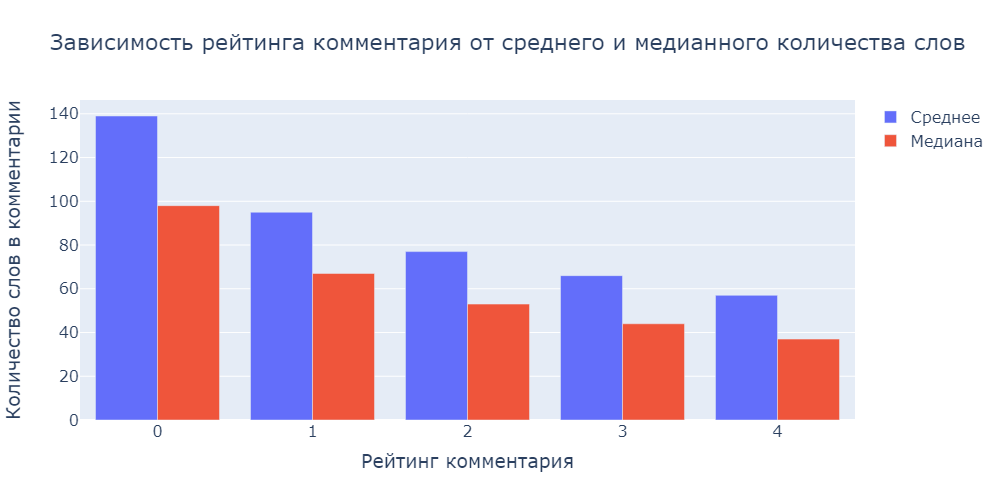

In [45]:
# сгруппируем данные для удобства
text_length_score_df = train_df.groupby('score')['text_length'].agg(['mean', 'median']).round().reset_index()

# строим график
text_score_length_plot = go.Figure()

# для среднего
text_score_length_plot.add_trace(go.Bar(
   x=text_length_score_df['score'],
   y=text_length_score_df['mean'],
   name='Среднее')
)

# для медианы
text_score_length_plot.add_trace(go.Bar(
   x=text_length_score_df['score'],
   y=text_length_score_df['median'],
   name='Медиана')
)

text_score_length_plot.update_layout(
   title='Зависимость рейтинга комментария от среднего и медианного количества слов',
   xaxis_title='Рейтинг комментария',
   yaxis_title='Количество слов в комментарии',
   font=dict(size=16),
   width=1000
)

text_score_length_plot.show('png')

**Вывод:**  
Очевидно, зависимость есть и она прямо пропорциональна. С уменьшением количества слов (в среднем и по медиане) снижается и рейтинг комментария. При этом самыми популярными, судя по этому графику, становятся комментарии, где в среднем около 139 слов, т.е. довольно длинная цепь рассуждений/повествования.
________________________________________________________________________________

Теперь оценим зависимость рейтинга комментария от его семантической окраски с учетом библиотеки.

В библиотеке Sentiment Intensity Analyzer ключевая метрика называется compound. Она может принимать отрицательные (для негативных комментариев) и положительные (для позитивных) значения. Для более полной картины, чтобы не перемешивать (+) и (-) значения и не получить ерунду, будет рассматривать их по отдельности.

In [21]:
# отделяем отрицательную оценку и группируем по рейтингу комментария
neg_mask = train_df[train_df['text_compound'] < 0]
sia_neg_df = neg_mask.groupby('score')['text_compound'].agg(['mean', 'median']).round(2).reset_index()

In [22]:
# отделяем неотрицательные оценки и группируем по рейтингу комментария
pos_mask = train_df[train_df['text_compound'] >= 0]
sia_pos_df = pos_mask.groupby('score')['text_compound'].agg(['mean', 'median']).round(2).reset_index()

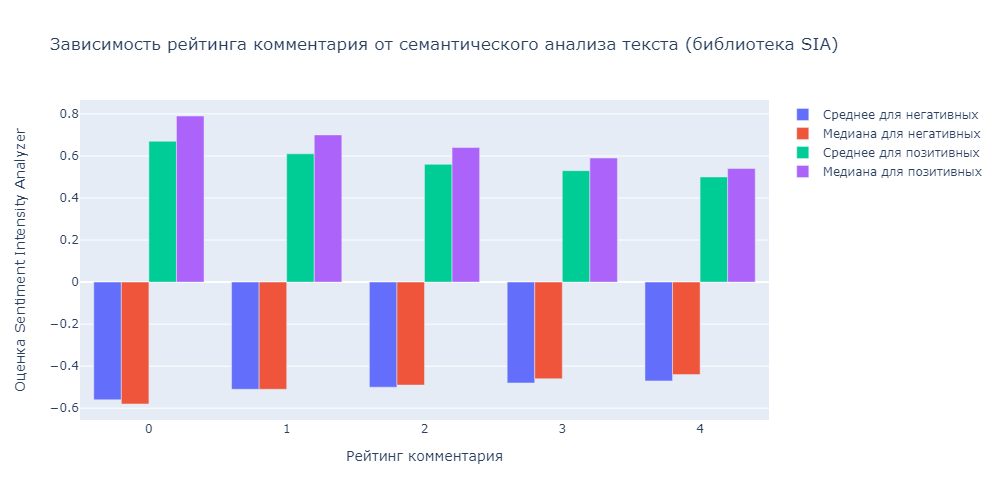

In [44]:
# для удобства будем использователь модуль go
sia_plot = go.Figure()

# среднее для негативных
sia_plot.add_trace(go.Bar(
   x=sia_neg_df['score'],
   y=sia_neg_df['mean'],
   name='Среднее для негативных')
)

# медиана для негативных
sia_plot.add_trace(go.Bar(
   x=sia_neg_df['score'],
   y=sia_neg_df['median'],
   name='Медиана для негативных')
)

# среднее для позитивных
sia_plot.add_trace(go.Bar(
   x=sia_pos_df['score'],
   y=sia_pos_df['mean'],
   name='Среднее для позитивных')
)

# медиана для позитиных
sia_plot.add_trace(go.Bar(
   x=sia_pos_df['score'],
   y=sia_pos_df['median'],
   name='Медиана для позитивных')
)

# добавляем читаемости
sia_plot.update_layout(
   title='Зависимость рейтинга комментария от семантического анализа текста (библиотека SIA)',
   xaxis_title='Рейтинг комментария',
   yaxis_title='Оценка Sentiment Intensity Analyzer',
   width=1000
)

sia_plot.show('png')

**Выводы:**  
Изначально мной был сделан неверный вывод, поэтому я и разделил график на + и - (по мнению библиотеки SIA) комментарии. Чем больше значение получил комментарий по модулю, тем более он экспресивен и эмоционален. И по графику мы видим очень четкую прямую зависимость - чем более яркий в семантическом плане комментарий, тем выше его рейтинг. При этом независимо от его позитивности или негативности.
________________________________________________________________________________

Теперь посмотрим есть ли зависимость между рейтингом и семантическим анализом поста и комментария для библиотеки SIA. Аналогично, для наглядности будем брать только средние значения.

In [24]:
# для комментария
# отделяем отрицательную оценку и группируем по рейтингу
text_neg = train_df[train_df['text_compound'] < 0]
text_sia_neg_df = text_neg.groupby('score')['text_compound'].mean().round(2).reset_index()

# отделяем неотрицательные оценки и группируем по рейтингу
text_pos = train_df[train_df['text_compound'] >= 0]
text_sia_pos_df = text_pos.groupby('score')['text_compound'].mean().round(2).reset_index()

In [25]:
# теперь для поста
# отделяем отрицательную оценку и группируем по рейтингу
post_neg = train_df[train_df['post_compound'] < 0]
post_sia_neg_df = post_neg.groupby('score')['post_compound'].mean().round(2).reset_index()

# отделяем неотрицательные оценки и группируем по рейтингу
post_pos = train_df[train_df['post_compound'] >= 0]
post_sia_pos_df = post_pos.groupby('score')['post_compound'].mean().round(2).reset_index()

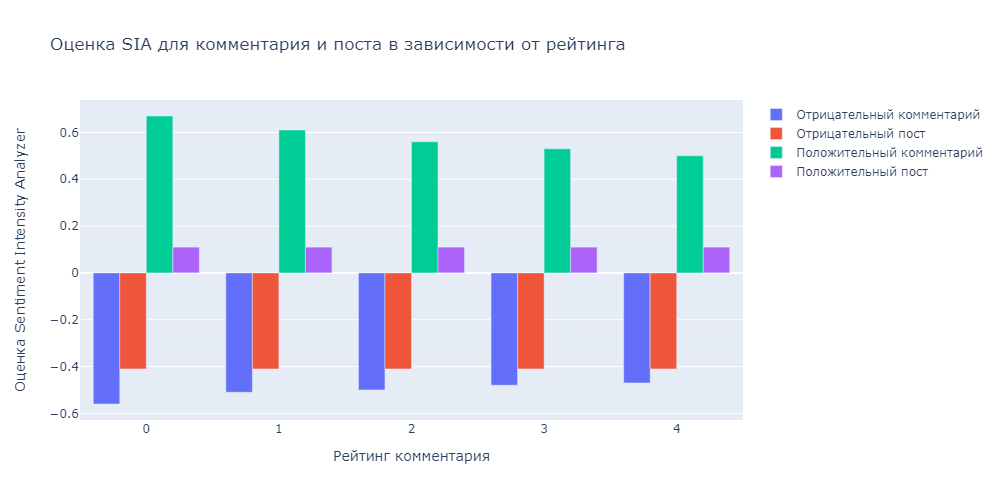

In [43]:
text_post_sia = go.Figure()

# - для комментария
text_post_sia.add_trace(go.Bar(
   x=text_sia_neg_df['score'],
   y=text_sia_neg_df['text_compound'],
   name='Отрицательный комментарий')
)
# - для поста
text_post_sia.add_trace(go.Bar(
   x=post_sia_neg_df['score'],
   y=post_sia_neg_df['post_compound'],
   name='Отрицательный пост')
)

# + для комментария
text_post_sia.add_trace(go.Bar(
   x=text_sia_pos_df['score'],
   y=text_sia_pos_df['text_compound'],
   name='Положительный комментарий')
)

# + для поста
text_post_sia.add_trace(go.Bar(
   x=post_sia_pos_df['score'],
   y=post_sia_pos_df['post_compound'],
   name='Положительный пост')
)


text_post_sia.update_layout(
   title='Оценка SIA для комментария и поста в зависимости от рейтинга',
   xaxis_title='Рейтинг комментария',
   yaxis_title='Оценка Sentiment Intensity Analyzer',
   width=1000
)

text_post_sia.show('png')

**Выводы:**  
В этом графике мы дополнили семантическую оценку комментария семантической оценкой поста. Сделанный ранее вывод можно смело дополнить: и для негативных постов, и для позитивных более высокая экспрессия комментария способствует его высокой значимости.
________________________________________________________________________________

In [47]:
train_df['diff_compound']

0         0.9417
1         0.7788
2         0.7684
3         0.0516
4         0.0000
           ...  
440530    0.3612
440531    0.7935
440532    0.1179
440533    0.1280
440534    0.4767
Name: diff_compound, Length: 440535, dtype: float64

Посмотрим работает ли это правило для библиотеки Afinn.

In [27]:
# отделяем отрицательную оценку и группируем по рейтингу
neg_mask = train_df[train_df['text_afinn_score'] < 0]
afinn_neg_df = neg_mask.groupby('score')['text_afinn_score'].agg(['mean', 'median']).round(2).reset_index()

In [28]:
# отделяем неотрицательные оценки и группируем по рейтингу
pos_mask = train_df[train_df['text_afinn_score'] >= 0]
afinn_pos_df = pos_mask.groupby('score')['text_afinn_score'].agg(['mean', 'median']).round(2).reset_index()

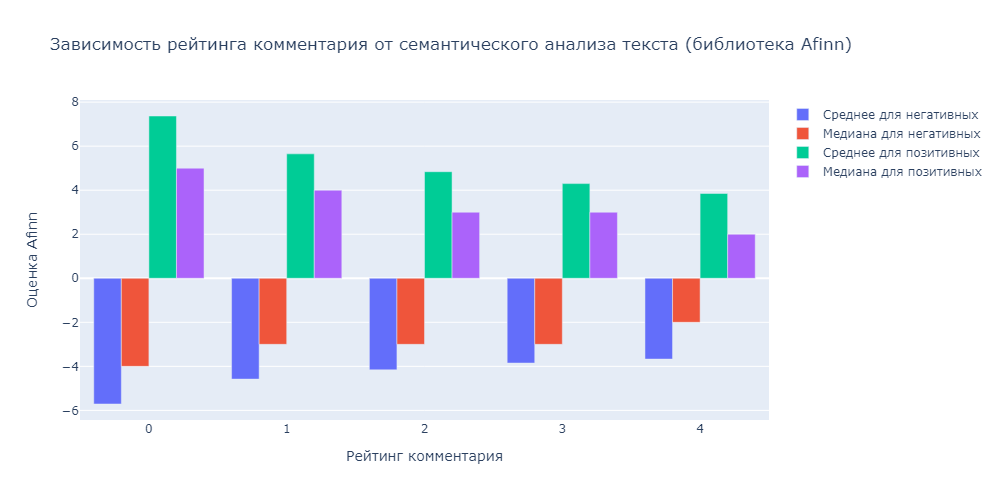

In [41]:
# сравнивать для наглядности буем также медианное и среднее значение
afinn_plot = go.Figure()

# для - среднего
afinn_plot.add_trace(go.Bar(
   x=afinn_neg_df['score'],
   y=afinn_neg_df['mean'],
   name='Среднее для негативных')
)

# для - медианы
afinn_plot.add_trace(go.Bar(
   x=afinn_neg_df['score'],
   y=afinn_neg_df['median'],
   name='Медиана для негативных')
)

# для + среднего
afinn_plot.add_trace(go.Bar(
   x=afinn_pos_df['score'],
   y=afinn_pos_df['mean'],
   name='Среднее для позитивных')
)

# для - среднего
afinn_plot.add_trace(go.Bar(
   x=afinn_pos_df['score'],
   y=afinn_pos_df['median'],
   name='Медиана для позитивных')
)

# добавляем подписи
afinn_plot.update_layout(
   title='Зависимость рейтинга комментария от семантического анализа текста (библиотека Afinn)',
   xaxis_title='Рейтинг комментария',
   yaxis_title='Оценка Afinn',
   width=1000
)

afinn_plot.show('png')

**Выводы:**  
Библиотека Afinn только подтвержает сделанный ранее вывод. При этом на этом графике картина даже более наглядная.
________________________________________________________________________________

Но, на всякий случай, посмотрим результаты библиотеки Blob.

In [30]:
# отделяем отрицательную оценку и группируем по рейтингу
neg_mask = train_df[train_df['text_blob_polarity'] < 0]
blob_neg_df = neg_mask.groupby('score')['text_blob_polarity'].agg(['mean', 'median']).round(2).reset_index()

In [31]:
# отделяем неотрицательные оценки и группируем по рейтингу
pos_mask = train_df[train_df['text_blob_polarity'] >= 0]
blob_pos_df = pos_mask.groupby('score')['text_blob_polarity'].agg(['mean', 'median']).round(2).reset_index()

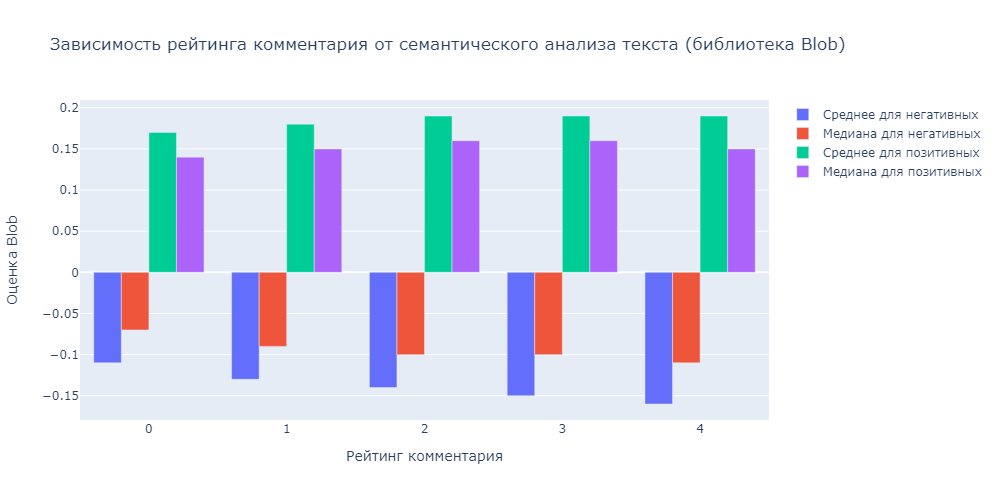

In [40]:
# сравнивать для наглядности будем также медианное и среднее значение
blob_plot = go.Figure()

# для - среднего
blob_plot.add_trace(go.Bar(
   x=blob_neg_df['score'],
   y=blob_neg_df['mean'],
   name='Среднее для негативных')
)

# для - медианы
blob_plot.add_trace(go.Bar(
   x=blob_neg_df['score'],
   y=blob_neg_df['median'],
   name='Медиана для негативных')
)

# для + среднего
blob_plot.add_trace(go.Bar(
   x=blob_pos_df['score'],
   y=blob_pos_df['mean'],
   name='Среднее для позитивных')
)

# для - среднего
blob_plot.add_trace(go.Bar(
   x=blob_pos_df['score'],
   y=blob_pos_df['median'],
   name='Медиана для позитивных')
)

# добавляем подписи
blob_plot.update_layout(
   title='Зависимость рейтинга комментария от семантического анализа текста (библиотека Blob)',
   xaxis_title='Рейтинг комментария',
   yaxis_title='Оценка Blob',
   width=1000
)

blob_plot.show('png')

**Выводы:**  
Здесь зависимость обратная, однако это связанно с особенностями анализа от библиотеки TextBlob.
________________________________________________________________________________

Поскольку у библиотеки TextBlob немного отличная логика вычислений, то мы не можем прямо сравнивать результаты Afinn/SIA с результатами TextBlob. Однако мы можем оценить другой важный аспект.  
Text Blob считает признак позитивности в диапозоне от 0 до 1, где 0-негативный, а 1-позитивный. Сравнив этот параметр для разных по рейтингу комментариев, мы сможем понять позитивные или негативные комментарии чаще попадают в топ.

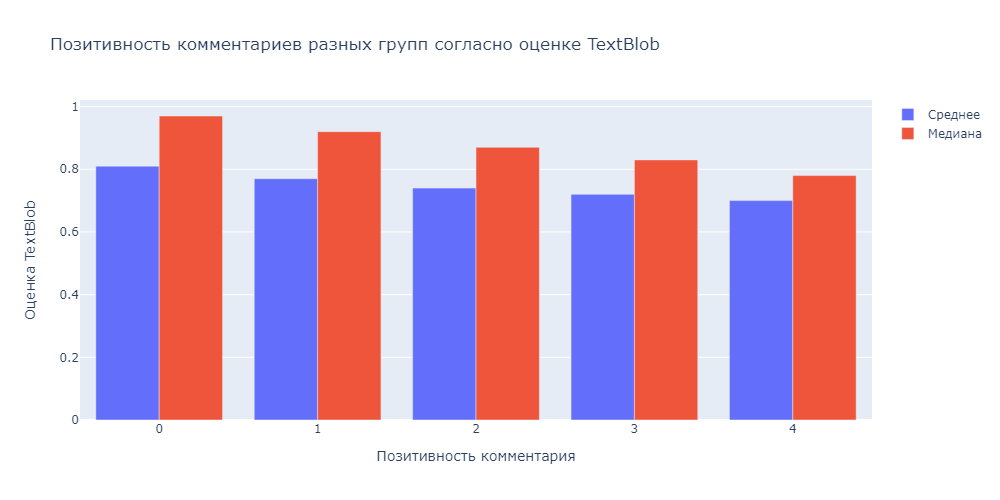

In [55]:
blob_pos_df = train_df.groupby('score')['text_blob_pos'].agg(['mean', 'median']).reset_index().round(2)

# строим график
blob_pos_plot = go.Figure()

# для среднего
blob_pos_plot.add_trace(go.Bar(
   x=blob_pos_df['score'],
   y=blob_pos_df['mean'],
   name='Среднее')
)

# для медианы
blob_pos_plot.add_trace(go.Bar(
   x=blob_pos_df['score'],
   y=blob_pos_df['median'],
   name='Медиана')
)

blob_pos_plot.update_layout(
   title='Позитивность комментариев разных групп согласно оценке TextBlob',
   xaxis_title='Позитивность комментария',
   yaxis_title='Оценка TextBlob',
   width=1000
)

blob_pos_plot.show('png')

**Выводы:**  
Однозначно более позитивные комментарии чаще попадают в топ.
________________________________________________________________________________

Теперь оценим влияние фактора субъективности текста.

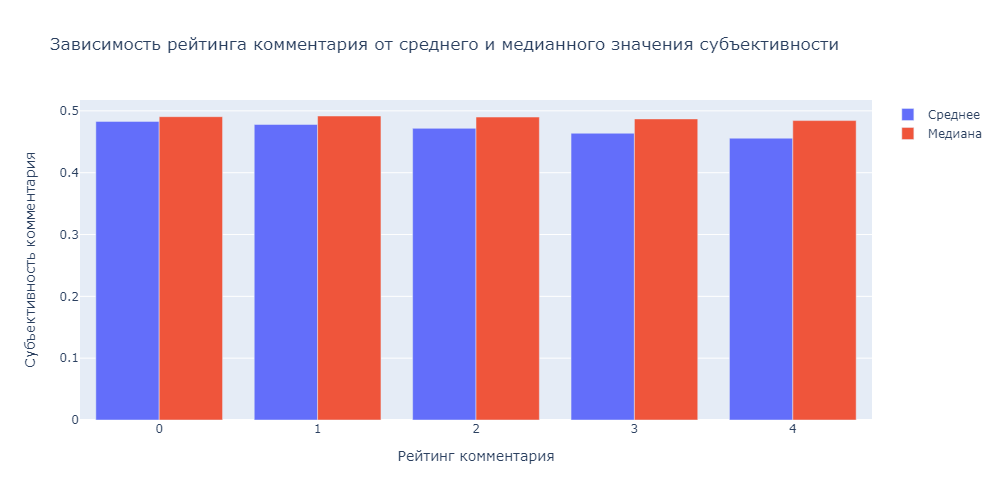

In [39]:
# сгруппируем данные для удобства
subjectivity_score_df = train_df.groupby('score')['text_blob_subject'].agg(['mean', 'median']).round(4).reset_index()

# строим график
subjectivity_score_plot = go.Figure()

# для среднего
subjectivity_score_plot.add_trace(go.Bar(
   x=subjectivity_score_df['score'],
   y=subjectivity_score_df['mean'],
   name='Среднее')
)

# для медианы
subjectivity_score_plot.add_trace(go.Bar(
   x=subjectivity_score_df['score'],
   y=subjectivity_score_df['median'],
   name='Медиана')
)

subjectivity_score_plot.update_layout(
   title='Зависимость рейтинга комментария от среднего и медианного значения субъективности',
   xaxis_title='Рейтинг комментария',
   yaxis_title='Субъективность комментария',
   width=1000
)

subjectivity_score_plot.show('png')

**Выводы:**  
Зависимость почти незаметная, скорее ее и вовсе нет, но сложно сказать без дополнительной оценки статистической значимости. Однако в сотых и тысячных значениях субъективность в более релевантных комментариях выше, т.е. основаных больше на личной информации, чем на фактах.
________________________________________________________________________________

Попробуем теперь оценить разницу между семантической оценкой поста и комментария в зависимости от рейтинга комментария.

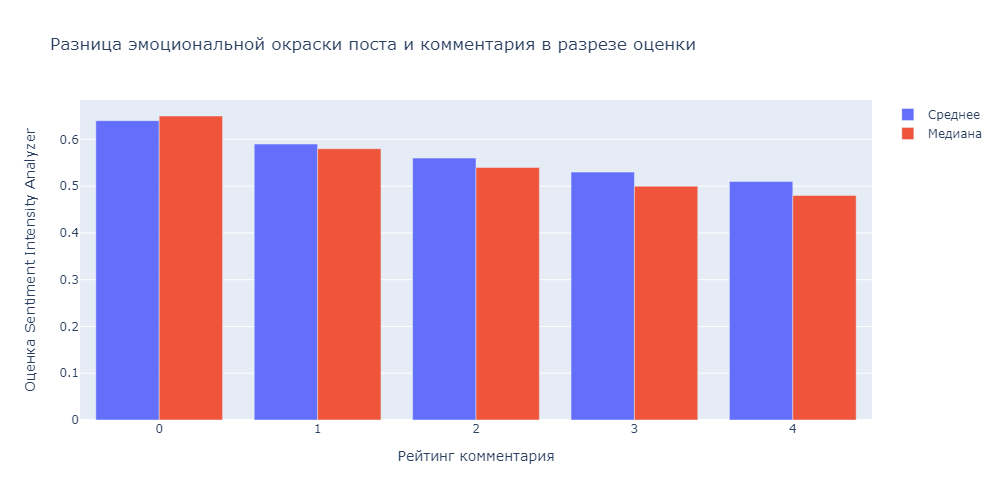

In [38]:
diff_compound_df = train_df.groupby('score')['diff_compound'].agg(['mean', 'median']).reset_index().round(2)

# строим график
diff_compound_plot = go.Figure()

# для среднего
diff_compound_plot.add_trace(go.Bar(
   x=diff_compound_df['score'],
   y=diff_compound_df['mean'],
   name='Среднее')
)

# для медианы
diff_compound_plot.add_trace(go.Bar(
   x=diff_compound_df['score'],
   y=diff_compound_df['median'],
   name='Медиана')
)

diff_compound_plot.update_layout(
   title='Разница эмоциональной окраски поста и комментария в разрезе оценки',
   xaxis_title='Рейтинг комментария',
   yaxis_title='Оценка Sentiment Intensity Analyzer',
   width=1000
)

diff_compound_plot.show('png')

**Выводы:**  
Кажется, что такой график мы уже видели, а вывод очевиден. Однако в этот раз мы рассматриваем абсолютную разницу в оценке эмоциональной окраски поста и комментария. Теперь мы понимаем, что чем большая разница в эмоциональной окраске комментария к посту, тем выше значимость такого комментария. Таким образом, можно подумать, что высказывание противоположной позиции (позитива на негатив или наоборот) имеет более высокие шансы оказаться в топе комментариев. Проверим это.
________________________________________________________________________________

Ранее мы получили признак diff_is_positive - признак, созданный с помощью библиотеки TextBlob, который показывает отличается ли позитивность поста и комментария:
- если 0 - значит пост и комментарий в одной эмоциональной окраске, т.е. оба негативные или оба позитивные
- если 1 - значит их окраска противоположна.
Соответственно, чем больше значение в каждой группе рейтинга комментария, тем больше в этом рейтинге противоположностей.

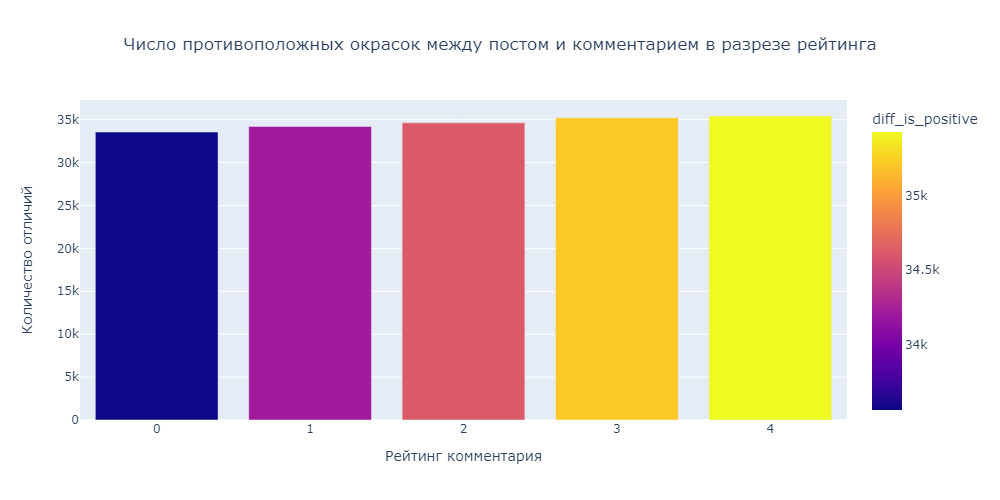

In [37]:
# группируем датасет по рейтингу
diff_positive_df = train_df.groupby('score')['diff_is_positive'].sum().reset_index()

# строим классическим способом график
diff_positive_plot = px.bar(
    data_frame=diff_positive_df,
    x='score',
    y='diff_is_positive',
    color='diff_is_positive',
    title='Число противоположных окрасок между постом и комментарием в разрезе рейтинга',
    width=1000
)

# добавляем подписи
diff_positive_plot.update_layout(
    xaxis_title='Рейтинг комментария',
    yaxis_title='Количество отличий',
    title=dict(x=.5, xanchor='center')
)

diff_positive_plot.show('png')

**Выводы:**  
А теперь мы видим, что противоположная эмоциональная окраска комментария посту (негатив на позитив или наоборот) с большей вероятностью попадет в категорию менее важных комментариев. Таким образом, эмоциональные и экспрессивные комментарии имеют больший рейтинг, но в это же время не должны иметь противоположный посту эмоциональный оттенок.
________________________________________________________________________________

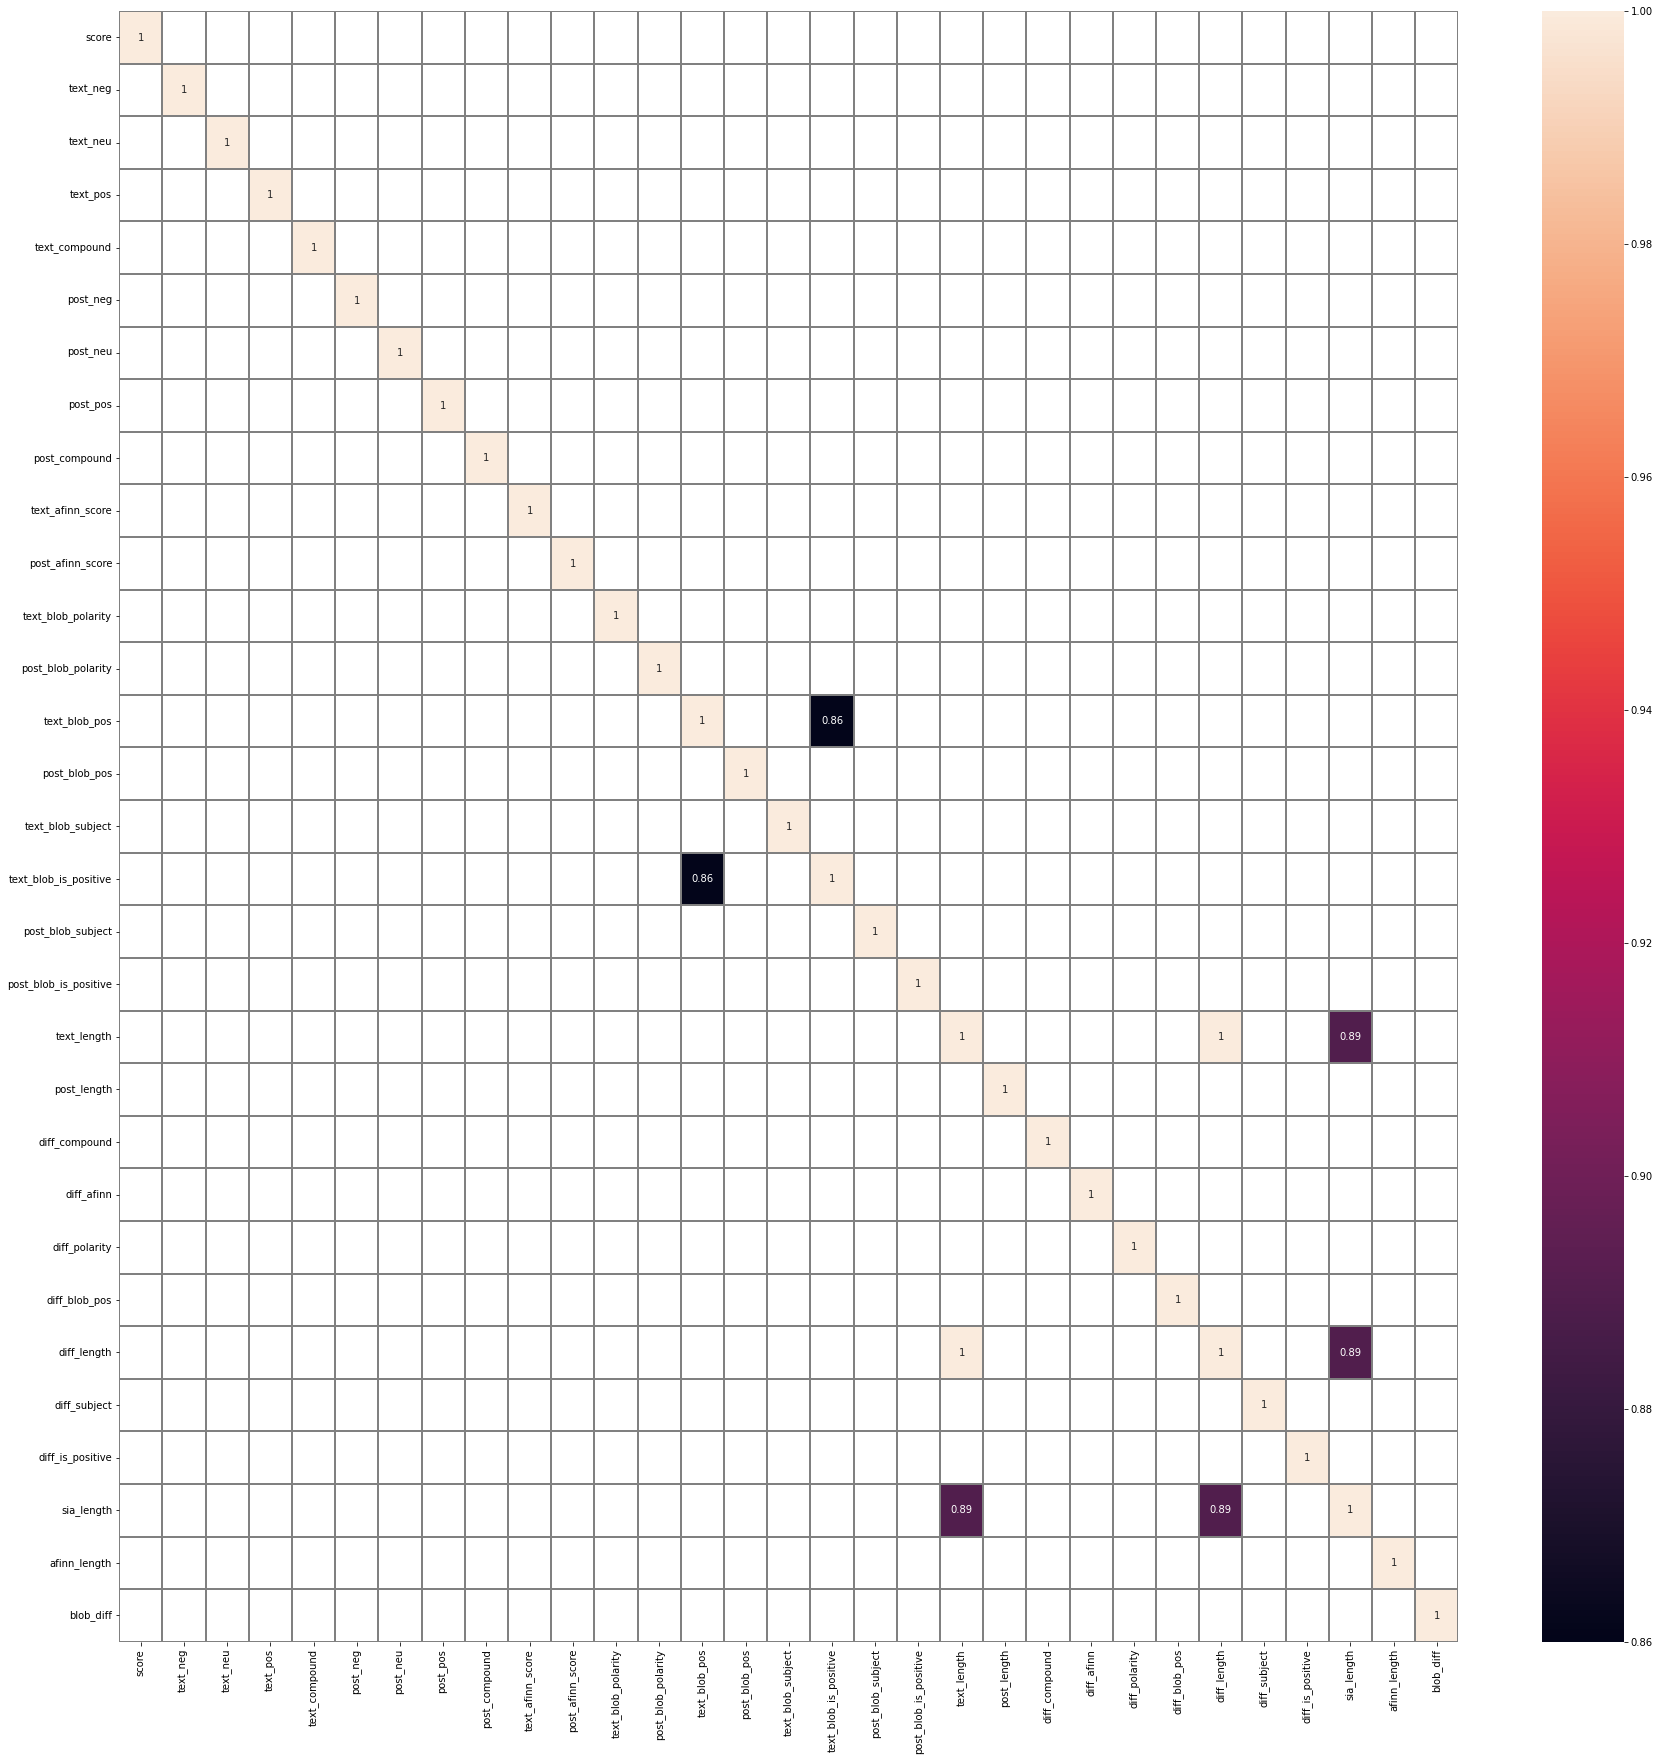

In [36]:
# проверим корреляцию признаков
corr = train_df.corr()

# сделаем красиво
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(round(corr[corr.abs() > 0.85], 2), annot=True, linewidths=0.1, linecolor='gray', ax=ax);

**Выводы:**  
Будем считать мультиколлинеарными признаки только те, которые имеют корреляцию >0.9.

In [63]:
def delete_feature(df):
    """избавляемся от очевидного мультиколлинеарного признака"""
    df = df.drop('diff_length', axis=1)
    
    return df


# применяем к выборкам
train_df = delete_feature(train_df)
test_df = delete_feature(test_df)

## <center> **Машинное обучение**

In [160]:
# для удобства работаем с копиями сэмплов
train_df_copy = train_df.drop(['text', 'text_sia'], axis=1)
test_df_copy = test_df.drop(['text', 'text_sia'], axis=1)

In [161]:
# создаем отложенную выборку для подсчета метрики
# она должна быть кратна 5, командно выбрали такое число для удобства
test_hold = train_df_copy.iloc[0:88100]
train_df_copy = train_df_copy.drop(range(88101))

In [162]:
# обозначаем набор предикторов и разбиваем выборку
X = train_df_copy.drop(['post', 'score'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, train_df_copy[["post", "score"]], test_size=0.2, random_state=42)

In [163]:
# проводим скалирование
scaler = RobustScaler()
scaler.fit(X_train)

# трансформируем
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

Применение скалирования практически не влияет на метрики. Однако с учетом отсутствия поиска выбросов (по причине запрета на сокращение датасета), с учетом совершенно разного масштаба всех признаков было принято решение об использование именно RobustScaler.

In [164]:
# подсчет групп по постам в тренировочных и валидационных данных
query_train = y_train.groupby("post")["post"].count().to_numpy()
query_valid = y_valid.groupby("post")["post"].count().to_numpy()

In [165]:
# строим модель
model = LGBMRanker(n_estimators=100,
                   random_state=42,
                   num_leaves=41,
                   learning_rate=0.002,
                   colsample_bytree=0.7)

# обучаем модель
model.fit(X_train, y_train.loc[:, "score"],
             group = query_train,
             eval_set=[(X_valid, y_valid.loc[:, "score"])],
             eval_group=[query_valid],
                )

[1]	valid_0's ndcg@1: 0.894851	valid_0's ndcg@2: 0.952396	valid_0's ndcg@3: 0.962116	valid_0's ndcg@4: 0.962919	valid_0's ndcg@5: 0.962953
[2]	valid_0's ndcg@1: 0.896194	valid_0's ndcg@2: 0.953183	valid_0's ndcg@3: 0.962655	valid_0's ndcg@4: 0.96343	valid_0's ndcg@5: 0.963462
[3]	valid_0's ndcg@1: 0.896325	valid_0's ndcg@2: 0.953203	valid_0's ndcg@3: 0.962693	valid_0's ndcg@4: 0.963467	valid_0's ndcg@5: 0.963492
[4]	valid_0's ndcg@1: 0.89643	valid_0's ndcg@2: 0.953262	valid_0's ndcg@3: 0.962739	valid_0's ndcg@4: 0.963517	valid_0's ndcg@5: 0.963542
[5]	valid_0's ndcg@1: 0.89682	valid_0's ndcg@2: 0.953408	valid_0's ndcg@3: 0.962854	valid_0's ndcg@4: 0.963651	valid_0's ndcg@5: 0.96368
[6]	valid_0's ndcg@1: 0.896814	valid_0's ndcg@2: 0.953441	valid_0's ndcg@3: 0.962902	valid_0's ndcg@4: 0.96367	valid_0's ndcg@5: 0.963699
[7]	valid_0's ndcg@1: 0.896911	valid_0's ndcg@2: 0.953458	valid_0's ndcg@3: 0.962914	valid_0's ndcg@4: 0.963693	valid_0's ndcg@5: 0.963717
[8]	valid_0's ndcg@1: 0.896662	v

LGBMRanker(colsample_bytree=0.7, learning_rate=0.002, num_leaves=41,
           random_state=42)

Подбор гиперпараметров не производился в связи с ограничением по времени, а также поскольку основная цель состазания - идеи, а не максимизация метрики.

In [166]:
# удаляем лишние столбцы
test_hold_df = test_hold.drop(['post', 'score'], axis=1)

# скалируем отложенную выборку
test_hold_df = scaler.transform(test_hold_df)

In [167]:
# предсказываем результат 
predictions = model.predict(test_hold_df)
print(predictions)

[-0.11340731 -0.04508105 -0.0595076  ... -0.0652606  -0.03565641
  0.00014847]


In [168]:
# предсказания в числовом виде, поэтому необходимо их проранжировать
def get_ranks(arr):
    
    # пустой список с номерами
    predicted_scores = []
    
    for i in range(0, len(arr), 5):
    
        group = predictions[i:i+5]
        sorted_group = sorted(group, reverse=True) #в обратном порядке 0-самый важный
        ranking_dict = {v:ind for ind,v in enumerate(sorted_group)}
        
        for j in group:
            predicted_scores.append(ranking_dict[j])
            
    return predicted_scores

# применяем функция к нашим непонятным результатам
predicted_scores = get_ranks(predictions)

In [169]:
# считаем метрику
print('nDCG на отложенной выборке {:.4f}'.format(ndcg_score([test_hold.loc[:, "score"]], [predicted_scores])))

nDCG на отложенной выборке 0.9165


In [170]:
# теперь повторяем все с тестовой выборкой
test_df_copy = test_df_copy.drop(['post', 'score'], axis=1)
test_df_copy = scaler.transform(test_df_copy)

In [171]:
# предсказываем финальные результаты
real_predictions = model.predict(test_df_copy)
print(real_predictions)

[ 0.0615807   0.07100453  0.0074463  ...  0.00288697 -0.00805691
  0.01344971]


In [172]:
# помещаем результаты в фрейм
test_df["score"] = get_ranks(real_predictions)
test_df

,post,text,score,text_sia,text_neg,text_neu,text_pos,text_compound,post_neg,post_neu,...,post_length,diff_compound,diff_afinn,diff_polarity,diff_blob_pos,diff_subject,diff_is_positive,sia_length,afinn_length,blob_diff
0,"iOS 8.0.1 released, broken on iPhone 6 models,...",I'm still waiting for them to stabilize wifi o...,4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.307,0.693,...,9,0.4767,2.0,0.600000,0.524825,0.200000,1,8.5806,36.0,9.446844
1,"iOS 8.0.1 released, broken on iPhone 6 models,...","For those who upgraded, no need to do a restor...",2,"{'neg': 0.09, 'neu': 0.82, 'pos': 0.09, 'compo...",0.090,0.820,0.090,0.0000,0.307,0.693,...,9,0.4767,1.0,0.400000,0.006892,0.400000,0,6.6738,14.0,0.096495
2,"iOS 8.0.1 released, broken on iPhone 6 models,...",Upgraded shortly after it was released and suf...,3,"{'neg': 0.065, 'neu': 0.891, 'pos': 0.045, 'co...",0.065,0.891,0.045,-0.2500,0.307,0.693,...,9,0.2267,2.0,0.374074,0.532831,0.114352,1,8.6146,76.0,20.247584
3,"iOS 8.0.1 released, broken on iPhone 6 models,...",I think they were under a lot of pressure on t...,1,"{'neg': 0.048, 'neu': 0.921, 'pos': 0.031, 'co...",0.048,0.921,0.031,-0.2023,0.307,0.693,...,9,0.2744,3.0,0.400000,0.352581,0.300000,1,10.9760,120.0,14.103244
4,"iOS 8.0.1 released, broken on iPhone 6 models,...",Fix for those who already updated: http:&#x2F...,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.307,0.693,...,9,0.4767,2.0,0.400000,0.074937,0.400000,1,0.9534,4.0,0.149873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70015,Why does Gmail hate my domain?,I send a LOT of emails each month (email newsl...,4,"{'neg': 0.04, 'neu': 0.82, 'pos': 0.14, 'compo...",0.040,0.820,0.140,0.9297,0.425,0.575,...,6,1.5016,5.0,0.812500,0.182772,0.521875,0,219.2336,730.0,26.684748
70016,Why does Gmail hate my domain?,I hit a similar problems when sending automate...,2,"{'neg': 0.172, 'neu': 0.828, 'pos': 0.0, 'comp...",0.172,0.828,0.000,-0.6597,0.425,0.575,...,6,0.0878,1.0,0.825000,0.069336,0.725000,0,2.1950,25.0,1.733392
70017,Why does Gmail hate my domain?,That's all a bit presumptive and inflammatory ...,0,"{'neg': 0.115, 'neu': 0.829, 'pos': 0.056, 'co...",0.115,0.829,0.056,-0.5423,0.425,0.575,...,6,0.0296,3.0,0.985714,0.133621,0.350000,0,1.5096,153.0,6.814694
70018,Why does Gmail hate my domain?,If the domain is bitbin.de and the mail server...,1,"{'neg': 0.06, 'neu': 0.744, 'pos': 0.196, 'com...",0.060,0.744,0.196,0.8807,0.425,0.575,...,6,1.4526,6.0,0.897917,0.178778,0.500000,0,92.9664,384.0,11.441809


**Выводы:**  

**1.** Построена успешная модель для ранжирования комментариев по их популярности.  

**2.** Достигнуто значение целевой переменной **nDCG** на отложенной выборке **0.9165**  

**3.** На основе проведенного анализа данных можно сделать следующие выводы и рекомендации комментаторам:

- Количество слов имеет прямое влияение на популярность комментария, поэтому рекомендовано использовать более длинные комментарии. По статистике, полученной на основе предложенных данных, наиболее популярные комментарии имеют в среднем около 140 слов.  
- Яркая эмоциональная окраска, экспрессивность даже для негативного комментария также способствует более высокому его рейтингу.  
- Но все же, чем позитивнее комментарий, чем положительнее его положительнее его эмоциональная окраска, тем более вероятно его попадание в топ.  
- Использование противоположного посту эмоционального окраса может привести к снижению рейтинга комментария. Таким образом, если пост имеет положительную семантику, не стоит использовать негативную экспрессию в своем комментарии.  
- Статистически субъективность комментария, т.е. использование фактов в качестве аргументов, не играет никакой роли. Комментатор вправе высказывать субъективное мнение, не использовать факты без боязни снижения рейтинга. 